# CNN's for Image Classification using Fast.ai Library

This code was created for the talk: CCN utilizando fast.ai 

The main objective is a classification model creation trained in Dogs vs Cats dataset extracted from kaggle.

We got 25.000 images classifificated as "dog" or "cat" avaliable for training and 12.500 images classiified as "dog" or "cat" for testing. 

Acording to Kaggle, the state of art for this task in 2013 was 80% of accuracy, our goal is beat this parameter.

## Download and Unzip Dataset

In [0]:
#download the data
!wget http://files.fast.ai/data/dogscats.zip

In [0]:
#unzip
!unzip dogscats.zip

## Setup Fast.ai Enviroment

In [0]:
#installing the packages
!pip3 install fastai torchvision-nightly
!pip3 install fastai fastai

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#loading the packages
from fastai.vision import *
from fastai.metrics import error_rate
from PIL import Image

In [6]:
#verifying the GPU is avaliabale
torch.cuda.is_available()

True

## Plotting some images in the dataset

In [0]:
PATH = "/content/dogscats/"

In [0]:
os.listdir(PATH)

['sample', 'test1', 'valid', 'train', 'models']

In [0]:
files = os.listdir(f'{PATH}valid/cats')[:10]
files

['cat.10940.jpg',
 'cat.5827.jpg',
 'cat.11957.jpg',
 'cat.2238.jpg',
 'cat.8433.jpg',
 'cat.2591.jpg',
 'cat.9955.jpg',
 'cat.6601.jpg',
 'cat.5132.jpg',
 'cat.125.jpg']

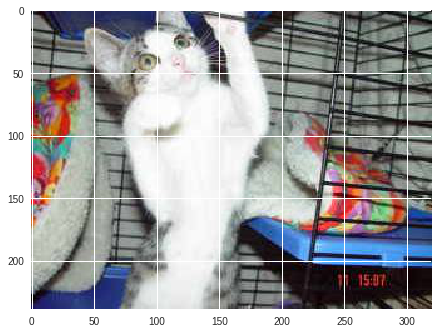

In [0]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [0]:
img.shape

(239, 320, 3)

In [0]:
img[:4,:4]

array([[[100, 109, 116],
        [103, 110, 116],
        [100, 103, 108],
        [ 85,  84,  89]],

       [[ 35,  44,  51],
        [ 44,  51,  57],
        [ 55,  58,  63],
        [ 58,  57,  62]],

       [[ 28,  37,  44],
        [ 26,  33,  39],
        [ 25,  28,  33],
        [ 23,  22,  27]],

       [[ 79,  88,  95],
        [ 71,  78,  84],
        [ 61,  64,  69],
        [ 51,  50,  55]]], dtype=uint8)

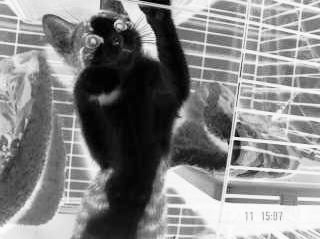

In [0]:
open_mask(f'{PATH}valid/cats/{files[0]}')

## Training the last layer

In fast.ai you don't need to start a model from scratch.

We will start using ResNet34 wich was created using the ImageNet dataset.

This network already can distinct many labels we gonna transfer that knowlodge to our model.



In [0]:
#databunch creation
bs = 64
data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=224, bs = bs).normalize(imagenet_stats)

In [0]:
#looking the databunch
data

In [0]:
#showing some images of the databunch
data.show_batch(rows = 3, figsize= (12,9))

In [0]:
#model creation
learn = create_cnn(data, models.resnet34, metrics=[accuracy,error_rate, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


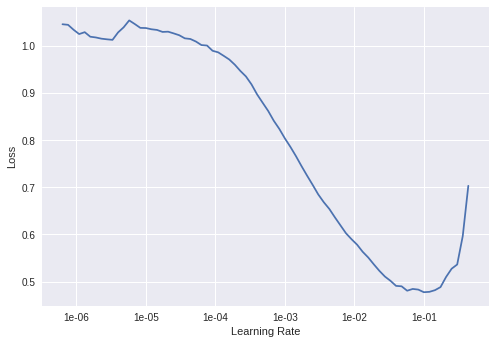

In [12]:
#finding the optimal learning rate
ln = learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-1 / 2
n_epoch = 2

In [14]:
learn.fit_one_cycle(n_epoch, max_lr=slice(lr))

epoch,train_loss,valid_loss,error_rate,time
1,0.082358,0.054668,0.016500,06:47
2,0.031747,0.027093,0.010000,06:23


## Unfreezing layers and find new learning rates

In [0]:
#unfreeze all layers
learn.unfreeze()

In [16]:
#training the model again
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
1,0.062277,0.032300,0.012500,06:51


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


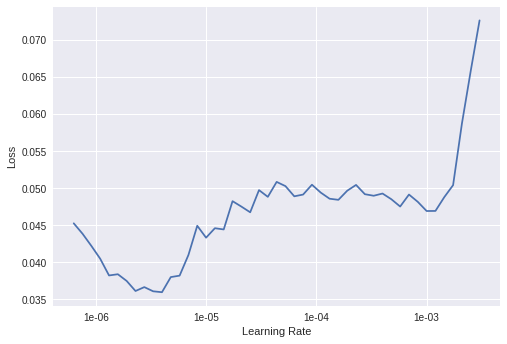

In [17]:
#finding a new learning rate
ln = learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
1,0.044965,0.030468,0.011500,07:08
2,0.030605,0.024814,0.008500,06:57


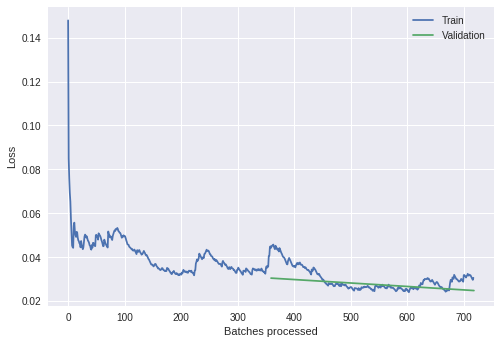

In [18]:
#training the model with the new learning rate
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))
learn.recorder.plot_losses()


In [0]:
#saving the layer
learn.save('stage-2')

## Making Predictions


In [0]:
learn.load("stage-2")

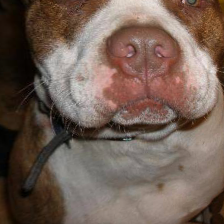

In [33]:
img = learn.data.train_ds[0][0]
img

In [35]:
# Predicting the labels of a single image
preds = learn.predict(img,thresh=0.001)
preds

(<fastai.core.Category at 0x7f0520651c88>,
 tensor(1),
 tensor([9.8265e-04, 9.9902e-01]))

## Looking at the results

In [20]:
#creating the interperter

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

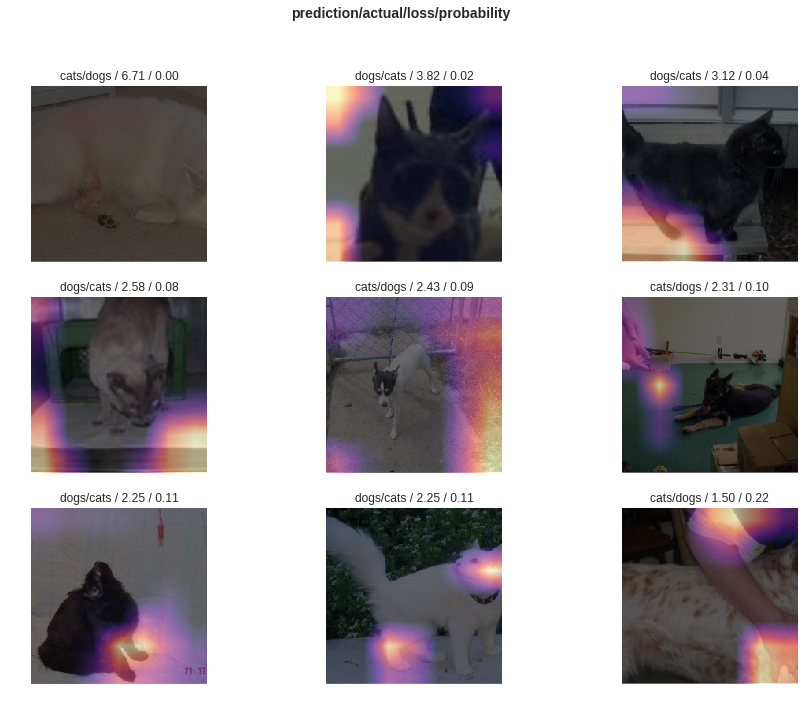

In [21]:
#plotting top_loses

interp.plot_top_losses(9, figsize=(15,11))

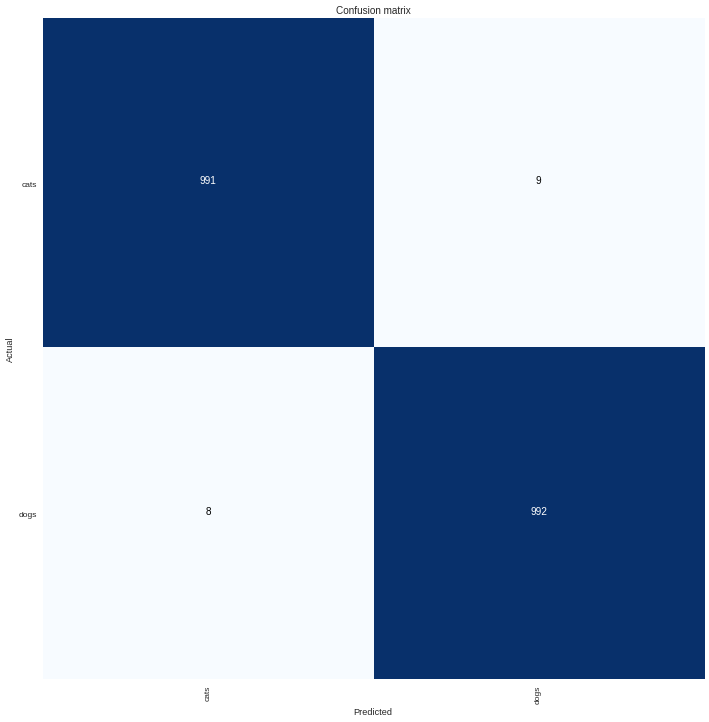

In [22]:
#confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)